<font size="6">
<p align="center"><b>pyLocalGLMnet</b> <br>
Eine Python Implementierung des Richman/Wüthrich Ansatzes</p>

# Inhalt 
[__Dependencies__](#dependencies)<br>
<br>
[__1. Einleitung__](#1-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[1.1 Dependencies](#1_1-bullet) <br>
<br>

[__2. Datensatz 1: Künstlicher Datensatz__](#2-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Künstlichen Datensatz erzeugen](#2_1-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 LocalGLMnet](#2_2-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.1 GLM](#2_2_1-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.2 LocalGLMnet](#2_2_2-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.3 Performance Benchmark](#2_2_3-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Auswertung](#2_3-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.1 Variable Selection](#2_3_1-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.2 Feature Contribution](#2_3_2-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.3 Interaction Strengths](#2_3_3-bullet) <br>
<br>

[__3. Datensatz 2: freMTPL2freq__](#3-bullet)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Preprocessing](#3_1-bullet) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.2 LocalGLMnet trainieren](#3_2-bullet) <br>
<br>

[__4. Zusammenfassung und Fazit__](#4-bullet)<br>
<br>
[__Literaturverzeichnis__](#literatur)

# Dependencies <a class="anchor" id="dependencies"></a>

In [36]:
from tensorflow import keras
import tensorflow as tf
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
from scipy import interpolate
import scipy.stats as stats
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


<hr>

# 1. Einleitung <a class="anchor" id="1-bullet"></a>

<hr>

<font size="3">
In dem Paper <em>LocalGLMnet: interpretable deep learning for tabular data</em> beschreiben Richman & Wüthrich eine neue Struktur für Neuronale Netze, welche auf Generalisierten Linearen Modellen (GLMs) beruht [1]. Dies soll einen Kompromiss zwischen der hohen Performanz der klassischen vorwärts gerichteten Neuronalen Netzen und der Erklärbarkeit von GLMs schaffen. Der Grundgedanke besteht darin, dass die Koeffizienten des GLMs durch das Neuronale Netz bestimmt werden. Hierdurch können sie anders als bei einem klassischen GLM in Abhängigkeit von den Merkmalsausprägungen variieren. Für einen beschränkten Wertebereich können die Koeffizienten jedoch konstant erscheinen, weshalb von einem lokalen GLM gesprochen wird.
Um den Zusammenhang zwischen Attention-Gewichten zu den ursprünglichen Merkmalen beizubehalten und Rückschlüsse auf den Einfluss unterschiedlicher Merkmale zu erlauben, wird in der Netzstruktur eine Skip-Connection verwendet. Bevor die Attention-Gewichte als Parameter des GLMs verwendet werden, werden sie hierfür mit der entsprechenden ursprünglichen Merkmalsausprägung multipliziert. <br>
<br>
Im Folgenden soll die Modellierung des LocalGLMnet-Ansatzes in Python mithilfe der Tensorflow Implementierung der Keras API dargestellt werden. Hierfür wird, wie auch im ursprünglichen Paper, zuerst ein synthetischer Datensatz betrachtet. Dies erlaubt durch das Wissen über den tatsächlichen Regressionszusammenhangs die Betrachtung der Möglichkeiten sowie Grenzen des Ansatzes. Anschließend wird wie auch im Paper der Einsatz des LocalGLMnet an einem realen Sachverhalt, der Vorhersage der Versicherungsfälle einer Kfz-Haftplicht, dargestellt. Die Verwendung der selben Datensätze wie im Paper ermöglicht das leichte Nachvollziehen der Schritte von Richman & Wüthrich und der Umsetzung in Python. <br>
Abschließend sollen Vor- und Nachteile sowie mögliche Weiterentwicklungen gegenübergestellt werden.

<hr>

# 2. Datensatz 1: Künstlicher Datensatz <a class="anchor" id="2-bullet"></a>

<hr>

## 2.1 Künstlichen Datensatz erzeugen <a class="anchor" id="2_1-bullet"></a>

<font size="3">
Der synthetische Datensatz besteht aus insgesamt 8 Merkmalen. x7 und x8 haben keinen Einfluss auf die Zielvariable. x8 ist jedoch zu 50% mit x2 korreliert. Der funktionale Zusammenhang der Zielvariable ergibt sich wie folgt:

\begin{equation} 
\mu\left( x \right)=\frac{1}{2}x_{1}-\frac{1}{4}x^2_{2}+\frac{1}{2}\left\lvert x_{3} \right\rvert sin\left( 2x_{3} \right)+\frac{1}{2}x_{4}x_{5}+\frac{1}{8}x^{2}_{5}x_{6}
\end{equation}

Die Merkmalsausprägungen werden mithilfe des Zufallsgenerators von Numpy auf Basis einer Standardnormalverteilung erzeugt. Hierdurch sind die Merkmale bereits standardisiert, d. h. alle haben den Mittelwert µ=0 und std=1. Bei einem anderen Datensatz müssten die Merkmale zuerst standardisiert werden, damit die Werte die selbe Größenordnung haben. Da die Daten künstlich erzeugt werden, wird sowohl ein Trainings- als auch Testdatensatz mit 100000 Beobachtungen erzeugt. Bei einem realen Datensatz müsste der vorhandene Datensatz entsprechend aufgeteilt werden (bspw. 80:20).

In [2]:
# Zielfunktion
def target_variable(x):
    return (
        (1 / 2) * x[0]
        - (1 / 4) * (x[1] ** 2)
        + (1 / 2) * abs(x[2]) * math.sin(2 * x[2])
        + (1 / 2) * x[3] * x[4]
        + (1 / 8) * (x[4] ** 2) * x[5]
    )


In [3]:
# Random Number Generator
rng = np.random.default_rng(seed=10)

# Trainingsdatensatz (n = 100.000) erzeugen (Variablen x1, x3, x4, x5, x6, x7)
x1_train = rng.standard_normal(size=(100000, 1))
x3_7_train = rng.standard_normal(size=(100000, 5))

# Variablen x2, x8 mit 50 % Korrelation erzeugen
cov_matrix = [[1, 0.5], [0.5, 1]]
x2_x8_train = rng.multivariate_normal(mean=[0, 0], cov=cov_matrix, size=100000)

# Trainingsdatensatz zusammenfügen und Zielvariable y bestimmen
x_train = np.column_stack((x1_train, x2_x8_train[:, 0], x3_7_train, x2_x8_train[:, 1]))
y_train = np.array(list(map(target_variable, x_train[:, 0:7])))


In [4]:
# Testdatensatz (n = 100.000) erzeugen (Variablen x1, x3, x4, x5, x6, x7)
x1_test = rng.standard_normal(size=(100000, 1))
x3_7_test = rng.standard_normal(size=(100000, 5))

# Variablen x2, x8 mit 50 % Korrelation erzeugen
x2_x8_test = rng.multivariate_normal(mean=[0, 0], cov=cov_matrix, size=100000)

# Testdatensatz zusammenfügen und Zielvariable y bestimmen
x_test = np.column_stack((x1_test, x2_x8_test[:, 0], x3_7_test, x2_x8_test[:, 1]))
y_test = np.array(list(map(target_variable, x_test[:, 0:7])))


## 2.2 LocalGLMnet <a class="anchor" id="2_2-bullet"></a>

<font size="3">
In diesem Kapitel soll auf Basis der Trainingsdaten zuerst ein klassisches GLM und ein LocalGLMnet trainiert werden. Anschließend bietet sich der Vergleich der Vorhersgegenauigkeit beider Modelle an.

### 2.2.1 GLM <a class="anchor" id="2_2_1-bullet"></a>

<font size="3">
Generalisierte Lineare Modelle, kurz GLM, erweitern klassische lineare Regressionsfunktionen, so dass auch nicht-lineare Zusammenhänge abgebildet werden können. Grundsätzlich bestehen hierfür GLMs aus drei Komponenten: der systematischen Komponente, der Link-Funktion und der Zufallskomponente.
Bei der systematischen Komponente handelt es sich um die klassische Regressionsparameter einer linearen Funktion. Die Zufallskomponente beschreibt die Verteilung der Residuen einer klassischen linearen Regression. Während diese bei einer klassischen linearen Regression normalverteilt sein müssen, erlaubt ein GLM andere Verteilungen aus der Exponentialfamilie wie die Binomial- oder Poisson-Verteilung. Die Link-Funktion verbindet die Regressionsparameter mit der spezifizierten Zufallskomponente [3]. Abhängig von dem Problem für den ein GLM eingesetzt werden soll und den zugrundeliegenden Daten bieten sich unterschiedliche Zufallskomponenten und entsprechende Link-Funktionen an. Genaueres zu der Wahl der Link-Funktion findet sich bspw. in [3]. Unteranderem in Versicherungen werden GLMs vielseitig eingesetzt, da ihre Ergebnisse anhand der Koeffizienten gut interpretierbar sind.
<br><br>
Für den synthetischen Datensatz haben Richman & Wüthrich die Identity-Link Funktion verwendet. Das resultierende GLM entspricht also einer klassischen linearen Regression. Um ein GLM mit Python zu erzeugen bieten sich Bibliotheken wie <em>scikit-learn</em> oder <em>statsmodels</em> an.

In [5]:
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)


LinearRegression()

In [6]:
reg.coef_


array([ 4.97703641e-01, -3.29545557e-04,  2.56840469e-02,  1.51331338e-03,
       -8.67153257e-04,  1.27757822e-01, -1.00663138e-03,  3.06228290e-04])

### 2.2.2 LocalGLMnet <a class="anchor" id="2_2_2-bullet"></a>

<font size="3">
Entsprechend der Spezifikationen in Richman & Wüthrich 2022 wurde ebenfalls ein LocalGLMnet trainiert [1]. Es besitzt vier Hidden Layer.
Die Anzahl der zu erlernenden Attention Gewichten entspricht der Anzahl der Inputvariablen. Um die Skip-Connection zu realisieren wird dem Netz eine weitere Ebene hinzugefügt, welche das Skalarprodukt des Inputs und der Attention Gewichte bildet. Um ebenfalls den Intercept β0  abbilden zu können besitzt das Netz eine weitere Schicht mit einem Neuron. Durch das anpassen der Aktivierungsfunktion lassen sich verschiedene Link-Funktionen implementieren. Das LocalGLMnet speißt die Attention Gewichte in der letzten Schicht also direkt in das resultierende lokale GLM ein.

In [7]:
# Seed des Zufallsgenerators festlegen
tf.random.set_seed(10)


In [8]:
input = keras.Input(shape=(8), dtype="float32")

attention = input
attention = keras.layers.Dense(units=20, activation="tanh")(attention)
attention = keras.layers.Dense(units=15, activation="tanh")(attention)
attention = keras.layers.Dense(units=10, activation="tanh")(attention)
attention = keras.layers.Dense(units=8, activation="linear", name="Attention")(
    attention
)

# Skip-Connection
response = keras.layers.Dot(axes=1)([input, attention])

# Response Schicht = lokales GLM
response = keras.layers.Dense(units=1, activation="linear", name="Response")(response)


2023-02-13 23:01:32.384785: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
local_glm_net = keras.Model(inputs=input, outputs=response)
local_glm_net.compile(loss="mse", optimizer="nadam")
local_glm_net.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           180         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 15)           315         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 10)           160         dense_1[0][0]                    
______________________________________________________________________________________________

In [10]:
history = local_glm_net.fit(
    x_train, y_train, batch_size=32, epochs=10, validation_split=0.2
)


2023-02-13 23:01:32.686094: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
2500/2500 [==============================] - 4s 1ms/step - loss: 0.1680 - val_loss: 0.0637
Epoch 2/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0454 - val_loss: 0.0368
Epoch 3/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.0328 - val_loss: 0.0305
Epoch 4/10
2500/2500 [==============================] - 4s 1ms/step - loss: 0.0257 - val_loss: 0.0215
Epoch 5/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0154 - val_loss: 0.0115
Epoch 6/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0075 - val_loss: 0.0053
Epoch 7/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 8/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 9/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 10/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.003

### 2.2.3 Performance Vergleich <a class="anchor" id="2_2_3-bullet"></a>

<font size="3">
Bei einem Vergleich der Vorhersagegenauigkeit schneidet das LocalGLMnet deutlich besser ab als ein klassisches GLM. Dargestellt in Abbildung 1 wird gut ersichtlich, dass das LocalGLMnet den funktionalen Zusammenhang im Vergleich zum GLM sehr gut abbilden kann. Die Vorhersagen des LocalGLMnet haben einen MSE von gerade einmal ≈0,003 während das GLM ein MSE von ≈0,533 aufweist. Dies ist jedoch durch die generell hohe Vorhersagegenauigkeit von Neuronalen Netzen nicht verwunderlich. Wichtig ist das nichtsdestotrotz die Interpretierbarkeit der Vorhersagen bestehen bleibt. Dies wird im nächsten Abschnitt behandelt.

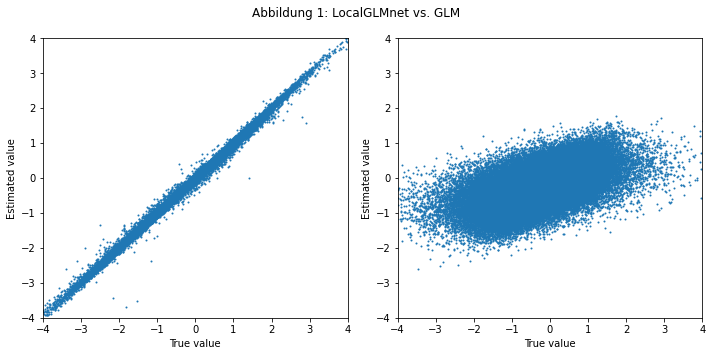

MSE LocalGLMnet: 0.002937464331290463
MSE GLM: 0.5331973708546169


In [11]:
pred_local = local_glm_net.predict(x_test)
pred_reg = reg.predict(x_test)

fig_performance = plt.figure(tight_layout=True, figsize=(10, 5))

spec = GridSpec(ncols=2, nrows=1, figure=fig_performance)
axs_perf = [
    fig_performance.add_subplot(spec[0, 0:1]),
    fig_performance.add_subplot(spec[0, 1:2]),
]

axs_perf[0].scatter(y_test, pred_local, s=1)
axs_perf[1].scatter(y_test, pred_reg, s=1)

for ax in axs_perf:
    ax.set_xlabel("True value")
    ax.set_ylabel("Estimated value")
    ax.set_xlim((-4, 4))
    ax.set_ylim((-4, 4))

fig_performance.suptitle("Abbildung 1: LocalGLMnet vs. GLM")
plt.show()

print("MSE LocalGLMnet: " + str(metrics.mean_squared_error(y_test, pred_local)))
print("MSE GLM: " + str(metrics.mean_squared_error(y_test, pred_reg)))


## 2.3 Auswertung <a class="anchor" id="2_3-bullet"></a>

### 2.3.1 Variable Selection <a class="anchor" id="2_3_1-bullet"></a>

<font size="3">
Ein Vorteil von LocalGLMnets gegenüber klassischen FFNs ist, dass sie sich zur Merkmalsselektion eignen.
Um einen ersten Eindruck vom Einfluss der Regression Attentions auf die Vorhersage sowie dem Zusammenhang zur ursprünglichen Inputvariable zu erhalten bietet sich ein Scatterplot der Regressionsgewichte in Abhängigkeit der Input Variablen an. Geringe laterale Verzerrungen bedeuten, dass es wenig Interaktionen der Regression Attention mit anderen Input Variablen gibt. Gleichzeitig lassen sich gewisse funktionale Zusammenhänge bereits durch den Plot erkennen. <br><br>
Streut ein Attention Wert für einen Großteil des Wertebereichs der Inputvariable um 0 scheint der Einfluss vernachlässigbar, das Merkmal kann demnach entfernt werden. Um ein Maß für die Streuung zu bieten haben Richman & Wüthrich einen empirischen Wald-Test entwickelt [1]. Hierbei wird dem Model eine zusätzliche Variable ohne Zusammenhang zur Zielvariable hinzugefügt. Anschließend wird auf Basis der Streuung des zugehörigen Attention Gewichts ein Konfidenzintervall berechnet. Hiermit lässt sich darauf hin die Coverage Ratio für jedes Attention Gewicht, also der Anteil der Gewichte die innerhalb der Grenzen liegen, berechnen. Ist diese kleiner als das Signifikanzniveau kann die Variable entfernt werden und das Modell erneut ohne diese trainert werden.
<br><br>
Bei dem verwendeten synthetischen Datensatz kann direkt β7 verwendet werden, da sie keinen Einfluss auf die tatsächliche Regressionsfunktion hat. Bei einem realen Datensatz bieten sich künstlich erzeugte normal- und gleichverteilte Merkmale mit μ=0 und std=1 an.

In [12]:
# Über die Methode get_weights() erhält man die Kantengewichte, sowie den Bias für jeder Schicht
# --> man erhält also eine Liste mit numpy Arrays die in der Länge der Anzahl der Ebenen * 2 entspricht
weights = local_glm_net.get_weights()
for i in weights:
    print(i.shape, end=" | ")


(8, 20) | (20,) | (20, 15) | (15,) | (15, 10) | (10,) | (10, 8) | (8,) | (1, 1) | (1,) | 

In [13]:
# Neues Model ohne Response-Schicht --> ermöglicht auslesen der Attention Gewichte
weights_local_glm = keras.Model(
    inputs=local_glm_net.input, outputs=local_glm_net.get_layer(name="Attention").output
)

# Gewichte bestimmen
beta_x = weights_local_glm.predict(x_test)

# Skalierung der Attention-Gewichte mithilfe des Gewichts der Response Schicht ( = Intercept beta_0)
beta_x_scaled = beta_x * weights[8]


In [14]:
# Merkmal 7 ist von der wahren Regressionsfunktion unabhängig
# --> Einsatz zur Berechnung des Konfidenzintervals

print("Mittelwert β7: " + str(beta_x_scaled[:, 6].mean()))
print("Standardabweichung β7: " + str(beta_x_scaled[:, 6].std()))

# Intervalgrenzen bestimmen
alpha = 0.001
bound = stats.norm.ppf(alpha / 2) * beta_x_scaled[:, 6].std()

print("Quantil " + str(1 - alpha / 2) + ": " + str(stats.norm.ppf(alpha / 2)))
print("Grenzen: ± " + str(abs(bound)))


Mittelwert β7: -0.0030089694
Standardabweichung β7: 0.014167937
Quantil 0.9995: -3.2905267314918945
Grenzen: ± 0.04661997690969506


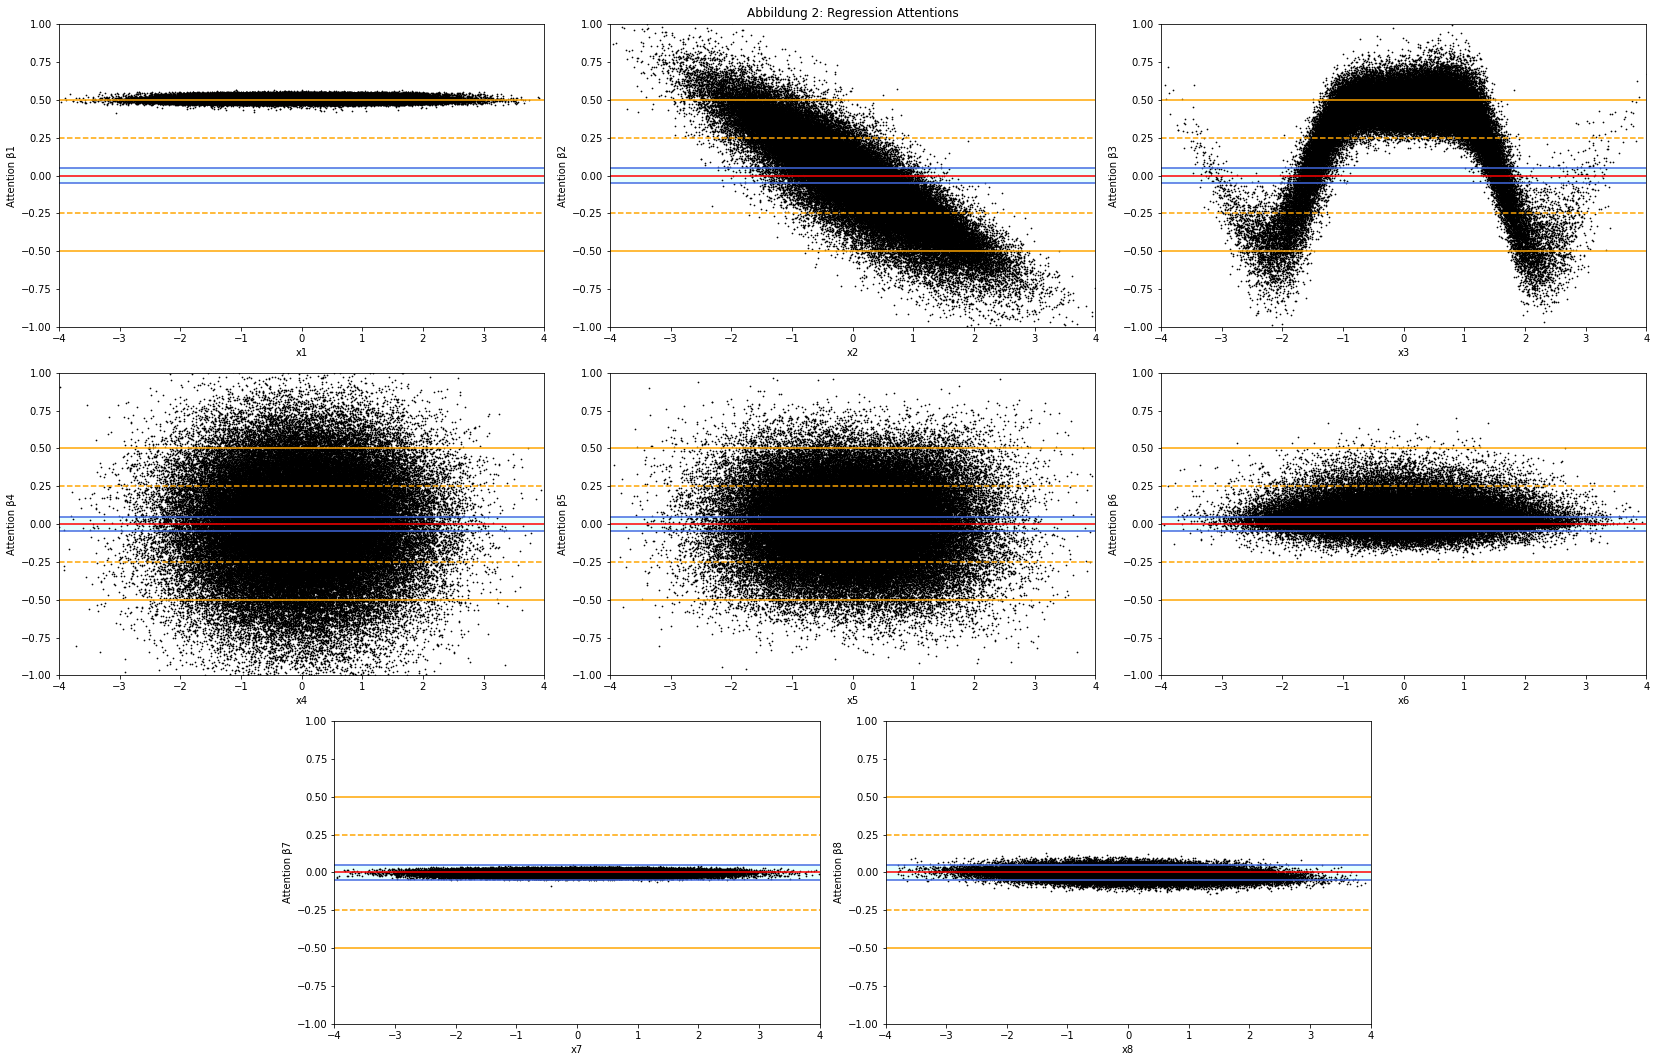

In [15]:
fig_attention = plt.figure(tight_layout=True, figsize=(30, 15))

# Gliederung der Subplots
spec = GridSpec(ncols=8, nrows=3, figure=fig_attention)
ax1_att = fig_attention.add_subplot(spec[0, 1:3])
ax2_att = fig_attention.add_subplot(spec[0, 3:5])
ax3_att = fig_attention.add_subplot(spec[0, 5:7])
ax4_att = fig_attention.add_subplot(spec[1, 1:3])
ax5_att = fig_attention.add_subplot(spec[1, 3:5])
ax6_att = fig_attention.add_subplot(spec[1, 5:7])
ax7_att = fig_attention.add_subplot(spec[2, 2:4])
ax8_att = fig_attention.add_subplot(spec[2, 4:6])
axs_att = [ax1_att, ax2_att, ax3_att, ax4_att, ax5_att, ax6_att, ax7_att, ax8_att]

for i in range(len(axs_att)):

    axs_att[i].hlines(y=0.5, xmin=-4, xmax=4, colors="orange")
    axs_att[i].hlines(y=-0.5, xmin=-4, xmax=4, colors="orange")

    axs_att[i].hlines(y=0.25, xmin=-4, xmax=4, colors="orange", linestyles="dashed")
    axs_att[i].hlines(y=-0.25, xmin=-4, xmax=4, colors="orange", linestyles="dashed")

    axs_att[i].hlines(y=0, xmin=-4, xmax=4, colors="red")

    # Intervalgrenzen
    interval = patches.Rectangle(
        xy=(-4, bound),
        height=2 * abs(bound),
        width=8,
        edgecolor="None",
        facecolor="lightcyan",
        alpha=0.8,
        zorder=1,
    )
    axs_att[i].hlines(y=bound, xmin=-4, xmax=4, colors="royalblue")
    axs_att[i].hlines(y=-bound, xmin=-4, xmax=4, colors="royalblue")
    axs_att[i].add_patch(interval)

    # Scatter Plot --> x: Werte der Inputfeatures, y: Attention Gewichte
    axs_att[i].scatter(x_test[:, i], beta_x_scaled[:, i], s=0.5, c="black")

    axs_att[i].set_xlim((-4, 4))
    axs_att[i].set_ylim((-1, 1))
    axs_att[i].set_xlabel("x" + str(i + 1))
    axs_att[i].set_ylabel("Attention β" + str(i + 1))

fig_attention.suptitle("Abbildung 2: Regression Attentions")
plt.show()


<font size="3">
<b>In dem Plot lassen sich bereits verschiedene funktionale Zusammenhänge und Interaktionen erkennen:</b><br>
<ul>
    <li><b>β1</b></li>
        <ul>
          <li>liegt relativ konstant bei 0.5</li>
          <li>wenig laterale Verzerrungen --> kaum Interaktionen mit anderen Inputvariablen</li>
        </ul><br>
    <li><b>β2, β3</b></li>
        <ul>
          <li>wenig laterale Verzerrungen --> kaum Interaktionen mit anderen Inputvariablen</li>
        </ul><br>
    <li><b>β4, β5, β6</b></li>
        <ul>
          <li>Attention Gewicht ≠ 0 --> Einfluss auf die Vorhersage</li>
          <li>laterale Verzerrungen --> Interaktionen mit anderen Inputvariablen</li>
        </ul><br>
    <li><b>β7, β8</b></li>
        <ul>
          <li>streuen um 0 --> β8 streut durch die Korrelation von x2 und x8 stärker (durch Wald-Test muss entschieden werden, ob x8 entfernt werden kann) </li>
        </ul>
</ul>

In [16]:
for i in range(8):
    if i != 6:
        size = beta_x_scaled.shape[0]
        coverage = np.count_nonzero(
            beta_x_scaled[:, i] < abs(bound)
        ) - np.count_nonzero(beta_x_scaled[:, i] < -abs(bound))
        coverage_ratio = coverage / size
        print("Coverage Ratio β" + str(i + 1) + ": " + str(coverage_ratio))


Coverage Ratio β1: 0.0
Coverage Ratio β2: 0.13429
Coverage Ratio β3: 0.02193
Coverage Ratio β4: 0.11431
Coverage Ratio β5: 0.15153
Coverage Ratio β6: 0.58437
Coverage Ratio β8: 0.88821


<font size="3">
<b>Es kann keine Inputvariable entfernt werden, da die Coverage Ratio von keinem Attention Gewicht ≥ 99,95% ist.</b>

### 2.3.2 Feature Contribution <a class="anchor" id="2_3_2-bullet"></a>

<font size="3">
Bevor die Attention Gewichte als Parameter des GLMs verwendet werden, wird das Skalarprodukt mit der ursprünglichen Inputvariable gebildet. Die resultierende Größe ist die Feature Contribution. Eine Visualisierung dieser in Abhängigkeit von der Inputvariable zeigt deutlicher den resultieren funktionalen Zusammenhang. Zur Verdeutlichung können zusätzlich Splines hinzugefügt werden, welche diesen approximieren.

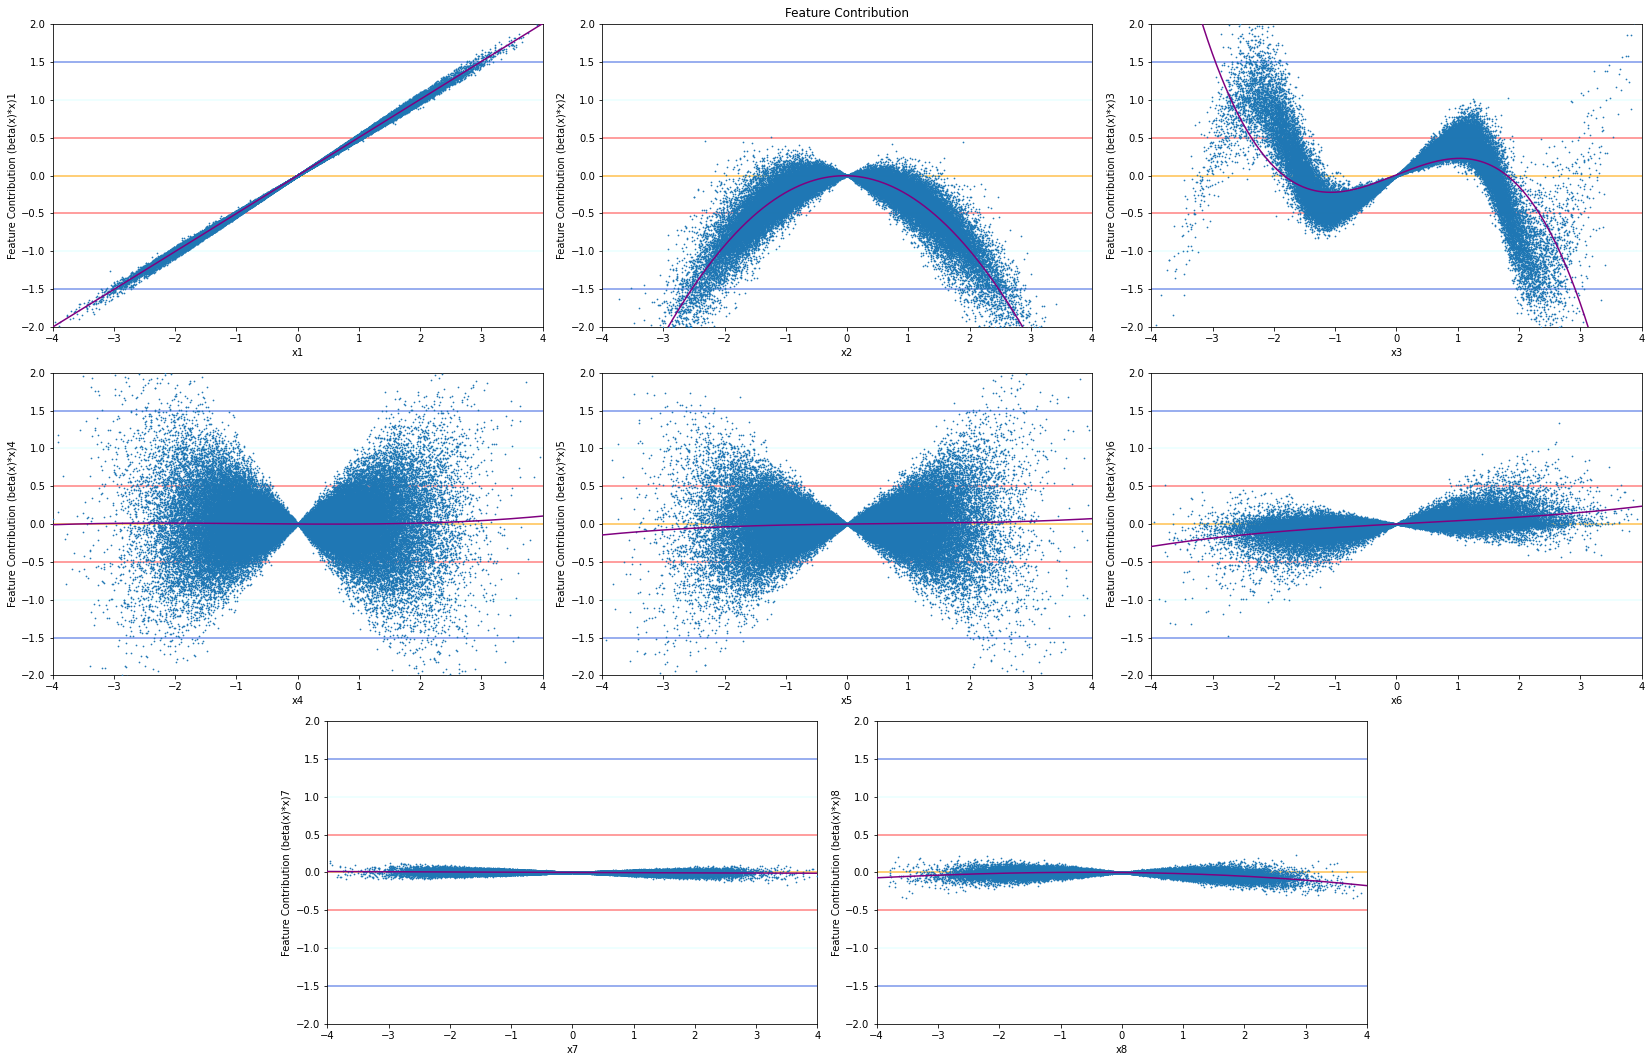

In [17]:
fig_contribution = plt.figure(tight_layout=True, figsize=(30, 15))

spec = GridSpec(ncols=8, nrows=3, figure=fig_contribution)
ax1_con = fig_contribution.add_subplot(spec[0, 1:3])
ax2_con = fig_contribution.add_subplot(spec[0, 3:5])
ax3_con = fig_contribution.add_subplot(spec[0, 5:7])
ax4_con = fig_contribution.add_subplot(spec[1, 1:3])
ax5_con = fig_contribution.add_subplot(spec[1, 3:5])
ax6_con = fig_contribution.add_subplot(spec[1, 5:7])
ax7_con = fig_contribution.add_subplot(spec[2, 2:4])
ax8_con = fig_contribution.add_subplot(spec[2, 4:6])

axs_con = [ax1_con, ax2_con, ax3_con, ax4_con, ax5_con, ax6_con, ax7_con, ax8_con]

xs = np.linspace(-4, 4, 1000)

for i in range(len(axs_con)):

    # Feature Contribution Splines berechnen
    # Feature Contribution = beta(xi)*xi
    contribution = np.column_stack([x_test[:, i], beta_x_scaled[:, i] * x_test[:, i]])
    con_ind = np.lexsort((contribution[:, 1], contribution[:, 0]))
    contribution_sorted = contribution[con_ind]
    con_spline = interpolate.UnivariateSpline(
        contribution_sorted[:, 0], contribution_sorted[:, 1]
    )

    # Hinzufügen von horizontalen Linien um die Stärke der Feature Contribution zu visualisieren
    axs_con[i].hlines(y=0, xmin=-4, xmax=4, colors="orange", alpha=0.7, zorder=1)

    axs_con[i].hlines(y=0.5, xmin=-4, xmax=4, colors="red", alpha=0.5, zorder=1)
    axs_con[i].hlines(y=-0.5, xmin=-4, xmax=4, colors="red", alpha=0.5, zorder=1)

    axs_con[i].hlines(y=1, xmin=-4, xmax=4, colors="lightcyan", alpha=0.7, zorder=1)
    axs_con[i].hlines(y=-1, xmin=-4, xmax=4, colors="lightcyan", alpha=0.7, zorder=1)

    axs_con[i].hlines(y=1.5, xmin=-4, xmax=4, colors="royalblue", alpha=0.7, zorder=1)
    axs_con[i].hlines(y=-1.5, xmin=-4, xmax=4, colors="royalblue", alpha=0.7, zorder=1)

    # Scatter Plot --> x: Werte der Inputfeatures, y:Feature Contribution (β(x)*x)
    axs_con[i].scatter(contribution[:, 0], contribution[:, 1], s=0.5, zorder=10)

    # Feature Contribution Spline plotten
    axs_con[i].plot(xs, con_spline(xs), color="purple", zorder=20)

    axs_con[i].set_xlim((-4, 4))
    axs_con[i].set_ylim((-2, 2))
    axs_con[i].set_xlabel("x" + str(i + 1))
    axs_con[i].set_ylabel("Feature Contribution (beta(x)*x)" + str(i + 1))

fig_contribution.suptitle("Feature Contribution")
plt.show()


<font size="3">
<ul>
    <li><b>β1</b></li>
        <ul>
          <li>lineare Funktion entsprechend der zugrundeliegenden Regressionsfunktion (<b>&frac12;x<sub>1</sub></b>)</li>
          <li>wenig laterale Verzerrungen --> kaum Interaktionen mit anderen Inputvariablen</li>
        </ul><br>
    <li><b>β2</b></li>
        <ul>
          <li>quadratischer Zusammenhang erkennbar (<b>&frac14;x<sub>2</sub><sup>2</sup></b>)</li>
          <li>wenig laterale Verzerrungen --> kaum Interaktionen mit anderen Inputvariablen</li>
        </ul><br>
    <li><b>β3</b></li>
        <ul>
          <li>Sinusfunktion (<b>&frac12; |x<sub>3</sub>| sin(2x<sub>3</sub>)</b>)</li>
          <li>wenig laterale Verzerrungen --> kaum Interaktionen mit anderen Inputvariablen</li>
        </ul><br>
    <li><b>β4, β5, β6</b></li>
        <ul>
          <li>laterale Verzerrungen --> starke Interaktionen mit anderen Inputvariablen</li>
        </ul><br>
    <li><b>β7, β8</b></li>
        <ul>
          <li> streuen um 0 --> β8 weist etwas mehr Interaktionen auf </li>
        </ul>
</ul>

## 2.3.3 Interaction Strengths <a class="anchor" id="2_3_3-bullet"></a>

<font size="3">

Um die zuvor bereits erkannten Interaktionen genauer zu analysieren bietet es sich an die Gradienten der Attention Gewichte zu untersuchen. Liegt keine Interaktion zwischen einem Attention Gewicht $j$ und einer Inputvariable $j'$ vor, so ist $∂β_j(x)/∂x_{j'}=0$.
<br>
Zur Darstellung der Gradienten bieten sich Regressionssplines an. Bei diesen handelt es sich um eine aus mehreren Polynomen zusammengesetzte Funktion, welche daher besonders "glatt" verläuft [4].
<br><br>
Im Paper verwenden Richman & Wüthrich die R Bibliothek <em>locfit</em> [1]. Da diese nicht für Python verfügbar ist muss auf eine andere Bibliothek ausgewichen werden. Eine Möglichkeit zur Modellierung eines Univariaten Splines bietet <em>scipy</em>. Dies entspricht nicht genau der Implementierung mittels <em>locfit</em>, ermöglicht jedoch das ziehen der selben Schlüsse.

In [18]:
# Gradienten bestimmen

gradients = []
x = tf.constant(x_train)

# Für jede Inputvariable wird ein Modell gefittet, um anschließend die partiellen Ableitungen auslesen zu können
for i in range(input.shape[-1]):

    beta = attention
    beta = keras.layers.Lambda(lambda x: x[:, i])(beta)
    grad_model = keras.Model(inputs=input, outputs=beta)
    grad_model.compile(loss="mse", optimizer="nadam")

    # GradientTape ermöglicht das auslesen der Gradienten
    with tf.GradientTape() as g:
        g.watch(x)
        pred_attention = grad_model.call(x)

    grad = g.gradient(pred_attention, x)

    # Array das sowohl den Wert von x, als auch den entsprechenden Wert von βk(x) enthält
    grad_wrt_x = np.column_stack((x[:, i].numpy(), grad.numpy()))

    # Um später die Splines zu modellieren muss die x-Komponente monoton steigend sein --> sortieren des Arrays
    ind = np.lexsort((grad_wrt_x[:, 2], grad_wrt_x[:, 0]))
    grad_wrt_x_sorted = grad_wrt_x[ind]

    # Gradienten in Liste speichern
    gradients.append(grad_wrt_x_sorted)


In [19]:
# Univariate Splines modellieren, um die Interaktion zwischen Features darzustellen
splines = []

# Für alle Attention Gewichte β
for i in range(input.shape[-1]):
    splines.append([])

    # Für alle Inputvariablen x
    for j in range(input.shape[-1]):
        splines[i].append(
            interpolate.UnivariateSpline(gradients[i][:, 0], gradients[i][:, j + 1])
        )


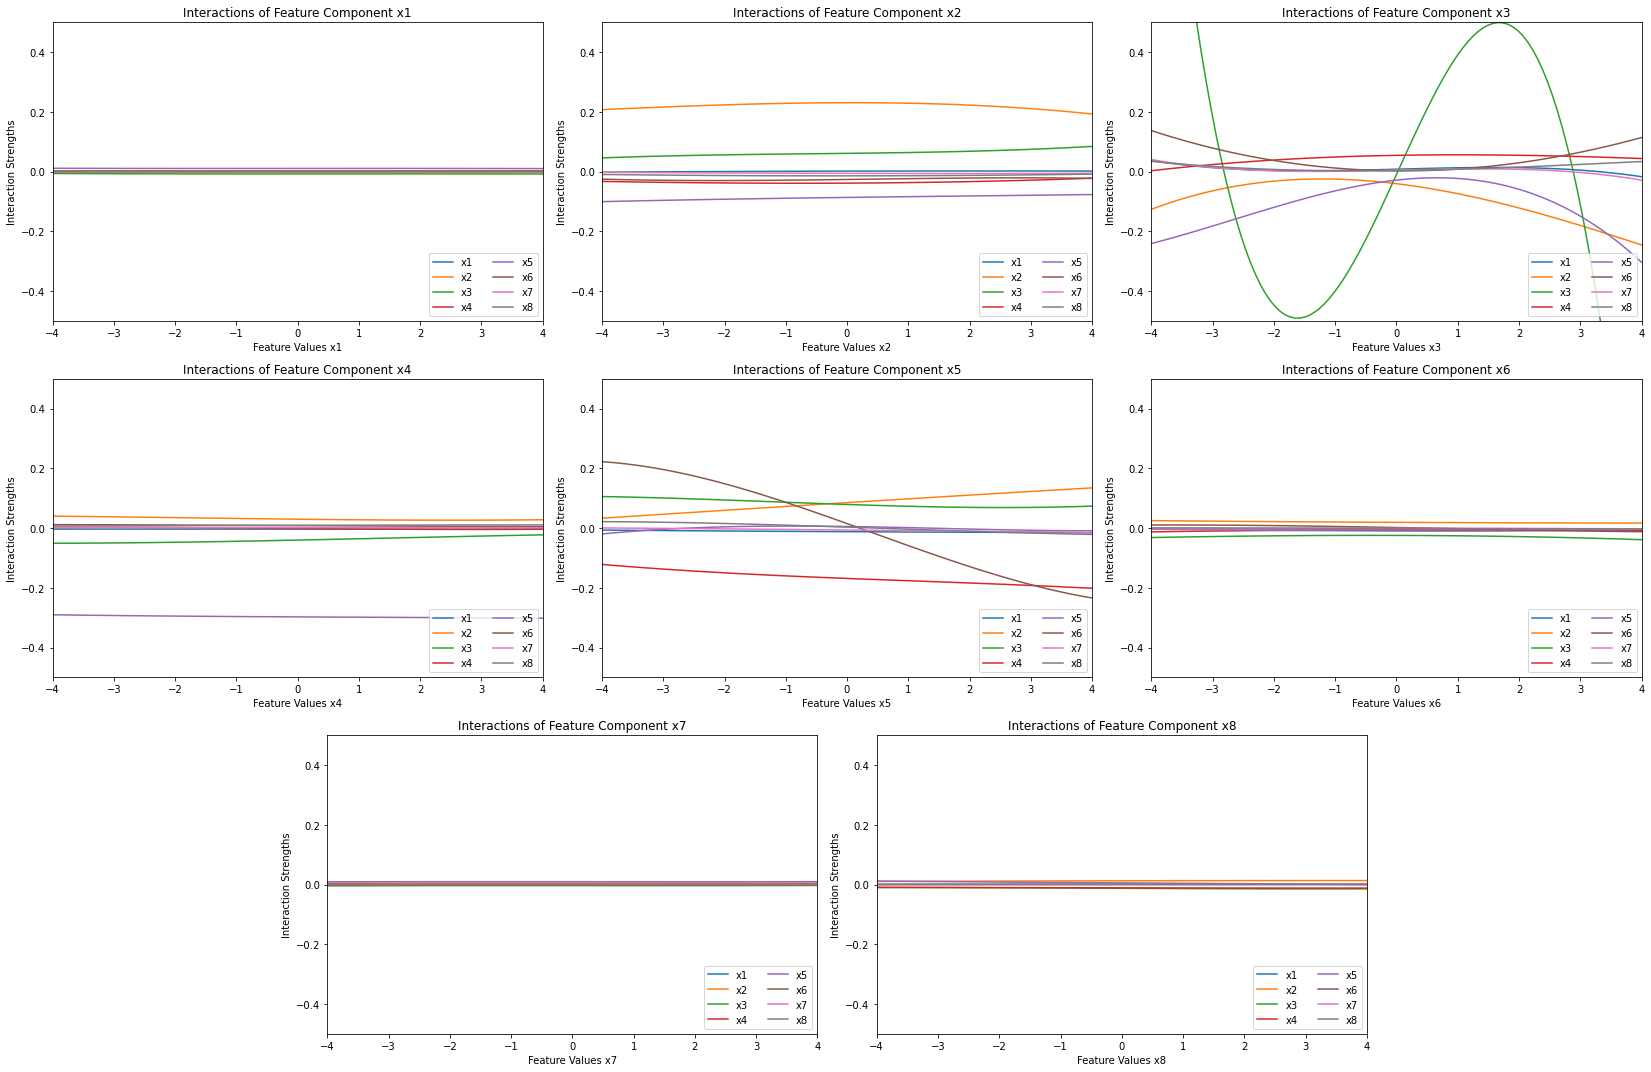

In [20]:
fig_spline = plt.figure(tight_layout=True, figsize=(30, 15))
spec = GridSpec(ncols=8, nrows=3, figure=fig_spline)
ax1_sp = fig_spline.add_subplot(spec[0, 1:3])
ax2_sp = fig_spline.add_subplot(spec[0, 3:5])
ax3_sp = fig_spline.add_subplot(spec[0, 5:7])
ax4_sp = fig_spline.add_subplot(spec[1, 1:3])
ax5_sp = fig_spline.add_subplot(spec[1, 3:5])
ax6_sp = fig_spline.add_subplot(spec[1, 5:7])
ax7_sp = fig_spline.add_subplot(spec[2, 2:4])
ax8_sp = fig_spline.add_subplot(spec[2, 4:6])

axs_sp = [ax1_sp, ax2_sp, ax3_sp, ax4_sp, ax5_sp, ax6_sp, ax7_sp, ax8_sp]

xs = np.linspace(-4, 4, 100)

for i in range(input.shape[-1]):
    axs_sp[i].set_xlim((-4, 4))
    axs_sp[i].set_ylim((-0.5, 0.5))
    axs_sp[i].set_xlabel("Feature Values x" + str(i + 1))
    axs_sp[i].set_ylabel("Interaction Strengths")
    axs_sp[i].set_title("Interactions of Feature Component x" + str(i + 1))

    for j in range(input.shape[-1]):
        axs_sp[i].plot(xs, splines[i][j](xs), label="x" + str(j + 1))

    axs_sp[i].legend(loc="lower right", ncol=2)

plt.show()


<font size="3">
<b>Interaktionen:</b>
<ul>
    <li><b>x1, x6, x7, x8</b></li>
        <ul>
          <li> Der Wert aller partiellen Ableitungen liegt konstant bei ≈0 </li>
          <li> → Keine Interaktionen (β ist konstant)</li>
        </ul><br>
    <li><b>x2</b></li>
        <ul>
          <li> Großteil der Werte um 0 konzentriert </li>
          <li> x2 ≠ 0</li>
          <li> → Sehr geringe Interaktionen mit anderen Variablen allerdings nicht-linearer Zusammenhang mit x2 (quadratisch)</li>
        </ul><br>
    <li><b>x3</b></li>
        <ul>
          <li> generell um 0 zentriert aber größere Streuung als bei x2</li>
          <li> x3 ≠ 0 → Sinus ähnelndes Verhalten </li>
          <li> → geringe Interaktionen mit anderen Variablen</li>
        </ul><br>
    <li><b>x4</b></li>
        <ul>
          <li> lineare Interaktion mit x5 (const. ≈ 0.3)</li>
          <li> → Sehr geringe Interaktionen mit anderen Variablen</li>
        </ul><br>
    <li><b>x5</b></li>
        <ul>
          <li> Geringe Interaktionen mit anderen Variablen </li>
          <li> Stärkste Interaktionen mit x4 (linear) und x5</li>
        </ul>
</ul>

<hr>

# 3. Datensatz #2: freMTPL2freq <a class="anchor" id="3-bullet"></a>
<hr>

https://www.kaggle.com/datasets/karansarpal/fremtpl2-french-motor-tpl-insurance-claims?resource=download

## 3.1 Preprocessing <a class="anchor" id="3_1-bullet"></a>

In [21]:
# Enthält Kundendaten von einer Kfz-Haftpflichtversicherung
freq = pd.read_csv("../data/freMTPL2freq.csv")

# Claim Anzahl entfernen (Erklärung siehe [2] Listing B.1)
freq = freq.drop(columns=["ClaimNb"])
freq["IDpol"] = freq["IDpol"].astype("int64")

In [22]:
# Enthält die Schadenshöhe für jeden Schaden
sev = pd.read_csv("../data/freMTPL2sev.csv")

# Schadenshöhe und Vorkommen nach Kunden-ID aggregieren
sev_agg = sev
sev_agg["ClaimNb"] = 1
sev_agg = sev_agg.groupby("IDpol").sum()[["ClaimNb", "ClaimAmount"]].reset_index()
sev_agg = sev_agg.rename(columns={"ClaimAmount": "ClaimTotal"})

In [23]:
# freq und sev zusammenführen --> Datensatz mit der korrekten Anzahl an Schadensmeldungen
freq = freq.merge(sev_agg, on="IDpol", how="left")
freq["ClaimNb"] = freq["ClaimNb"].fillna(0)
freq["ClaimTotal"] = freq["ClaimTotal"].fillna(0)
freq["VehBrand"] = pd.Categorical(freq["VehBrand"], categories=["B1","B2","B3","B4","B5","B6","B7","B8","B9","B10","B11","B12","B13","B14"])

# Area Codes einer Ordinalskala zuweisen (A=1, B=2,...)
freq["Area"] = pd.Categorical(freq["Area"], categories=["A","B","C","D","E","F"])
freq["Area"] = freq["Area"].cat.codes + 1
freq = freq.rename(columns={"Area":"AreaCode"})

# Binäre Variable "VehGas" den Codes 1 und 0 zuordnen (Diesel = 0, Regular = 1)
freq["VehGas"] = pd.Categorical(freq["VehGas"], categories = ["Diesel","Regular"])
freq["VehGas"] = freq["VehGas"].cat.codes

freq = freq.astype({"ClaimNb":"int64","Region":"category"})

# Alle Einträge mit mehr als 5 Schadensmeldungen entfernen:
freq = freq[freq["ClaimNb"]<=5]

# Exposure kann maximal 1 sein --> alle Beobachtungen mit höheren Werten auf 1 setzen:
freq["Exposure"] = freq["Exposure"].clip(lower=0,upper=1)

# Alle Einträge aus sev entfernen die jetzt nicht mehr in freq enthalten sind:
sev = sev[sev["IDpol"].isin(freq["IDpol"])][["IDpol","ClaimAmount"]]

In [24]:
freq.head()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,AreaCode,Density,Region,ClaimNb,ClaimTotal
0,1,0.10,5,0,55,50,B12,1,4,1217,Rhone-Alpes,0,0.0
1,3,0.77,5,0,55,50,B12,1,4,1217,Rhone-Alpes,0,0.0
2,5,0.75,6,2,52,50,B12,0,2,54,Picardie,0,0.0
3,10,0.09,7,0,46,50,B12,0,2,76,Aquitaine,0,0.0
4,11,0.84,7,0,46,50,B12,0,2,76,Aquitaine,0,0.0


In [25]:
sev.head()

,IDpol,ClaimAmount
0,1552,995.20
1,1010996,1128.12
2,4024277,1851.11
3,4007252,1204.00
4,4046424,1204.00


<font size="3">

<b>Wüthrich & Merz [2] S. 555:</b>
<ol>
    <li><b>IDpol:</b> policy number (unique identiﬁer)</li>
    <li><b>Exposure:</b> total exposure in yearly units (years-at-risk) and within (0, 1 ]</li>
    <li><b>Area:</b> area code (categorical, ordinal with 6 levels)</li>
    <li><b>VehPower:</b> power of the car (continuous)</li>
    <li><b>VehAge</b> age of the car in years</li>
    <li><b>DrivAge:</b> age of the (most common) driver in years</li>
    <li><b>BonusMalus:</b> bonus-malus level between 50 and 230 (with entrance level 100)</li>
    <li><b>VehBrand:</b> car brand (categorical, nominal with 11 levels)</li>
    <li><b>VehGas:</b> diesel or regular fuel car (binary)</li>
    <li><b>Density:</b> density of population per km 2 at the location of the living place of the driver</li>
    <li><b>Region:</b> regions in France (prior to 2016)(categorical)</li>
</ol>


In [26]:
# Stetige und binäre Merkmale standardisieren:
continous_columns = ["AreaCode", "BonusMalus", "Density", "DrivAge","VehAge", "VehPower"]
binary_columns = ["VehGas"]

freq_scaled = freq
scaler = StandardScaler()
freq_scaled[continous_columns+binary_columns] = scaler.fit_transform(freq_scaled[continous_columns+binary_columns])

In [27]:
# Zufällige Störvariablen hinzufügen, um später für die Regression Attentions ein Maß für die Streung um 0 definieren zu können

# Normalverteilte Zufallsvariable RandN
freq_scaled["RandN"] = rng.standard_normal(size=(freq_scaled.shape[0], 1))

# Gleichverteilte Zufallsvariable RandU (standardisiert)
freq_scaled["RandU"] = rng.uniform(size=(freq_scaled.shape[0], 1))
scaler_rand_u = StandardScaler()
freq_scaled["RandU"] = scaler_rand_u.fit_transform(freq_scaled[["RandU"]])

In [28]:
# Kategoriale Merkmale One-Hot Encoden (k-Kategorien führen zu k-1 Spalten)
categorical_columns = ["VehBrand","Region"]
freq_scaled = pd.get_dummies(freq_scaled, columns=categorical_columns, drop_first=True)

## 3.2 LocalGLMnet <a class="anchor" id="3_2-bullet"></a>

In [30]:
exposures = freq_scaled["Exposure"]
y_freq = freq_scaled["ClaimNb"]
x_freq = freq_scaled.drop(columns=["IDpol", "ClaimNb","ClaimTotal", "Exposure"])

In [37]:
x_freq_train, x_freq_test, y_freq_train, y_freq_test = train_test_split(x_freq, y_freq, test_size = 0.1)

vol = exposure

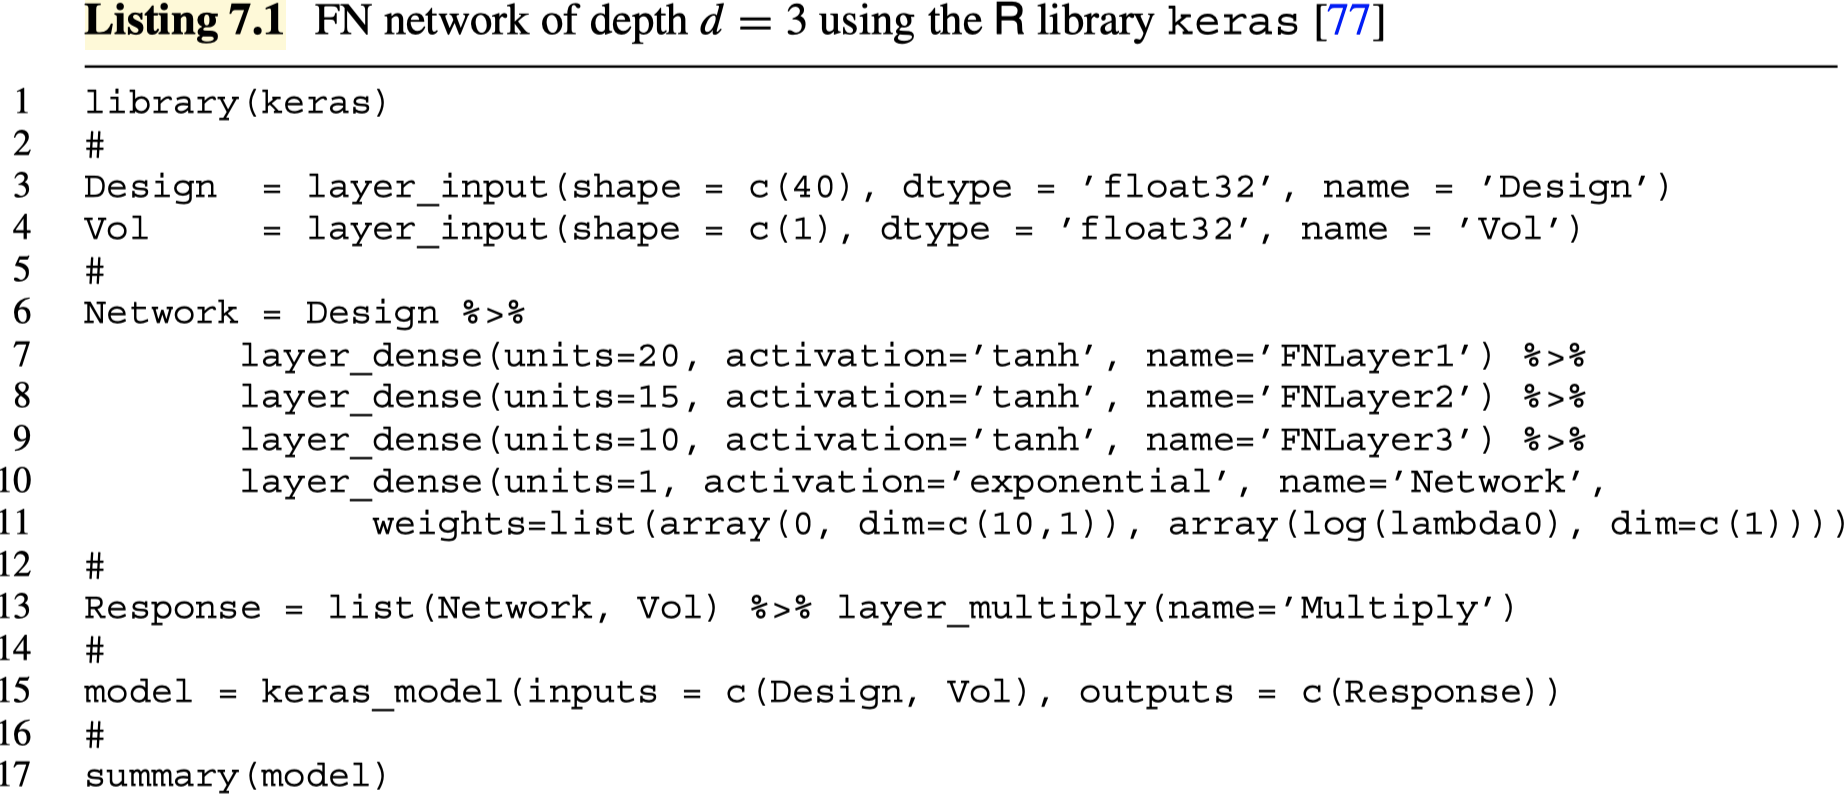

# 4. Zusammenfassung und Fazit <a class="anchor" id="4-bullet"></a>

# Literaturverzeichnis <a class="anchor" id="literatur"></a>

<font size="3">
[1] Ronald Richman und Mario V. Wüthrich. 2022. LocalGLMnet: interpretable deep learning for tabular data. Scandinavian Actuarial Journal 2022, 1, 71–95. DOI: <a href="https://doi.org/10.1080/03461238.2022.2081816">https://doi.org/10.1080/03461238.2022.2081816</a> <br>
<br>
[2] Mario V. Wüthrich and Michael Merz. 2023. Statistical Foundations of Actuarial Learning and its Applications. Springer International Publishing, Cham.<br>
<br>
[3] John A. Nelder and Robert W. M. Wedderburn. 1972. Generalized Linear Models. Journal of the Royal Statistical Society, Vol. 135, No. 3, 370–384 DOI: <a href="https://doi.org/10.2307/2344614">https://doi.org/10.2307/2344614</a>.<br>
<br>
[4] Martin Seehafer, Stefan Nörtemann, Jonas Offtermatt, Fabian Transchel, Axel Kiermaier, René Külheim, and Wiltrud Weidner. 2021. Actuarial Data Science. De Gruyter.